Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

Name	Description
1	Year	1987-2008
2	Month	1-12
3	DayofMonth	1-31
4	DayOfWeek	1 (Monday) - 7 (Sunday)
5	DepTime	actual departure time (local, hhmm)
6	CRSDepTime	scheduled departure time (local, hhmm)
7	ArrTime	actual arrival time (local, hhmm)
8	CRSArrTime	scheduled arrival time (local, hhmm)
9	UniqueCarrier	unique carrier code
10	FlightNum	flight number
11	TailNum	plane tail number
12	ActualElapsedTime	in minutes
13	CRSElapsedTime	in minutes
14	AirTime	in minutes
15	ArrDelay	arrival delay, in minutes
16	DepDelay	departure delay, in minutes
17	Origin	origin IATA airport code
18	Dest	destination IATA airport code
19	Distance	in miles
20	TaxiIn	taxi in time, in minutes
21	TaxiOut	taxi out time in minutes
22	Cancelled	was the flight cancelled?
23	CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24	Diverted	1 = yes, 0 = no
25	CarrierDelay	in minutes
26	WeatherDelay	in minutes
27	NASDelay	in minutes
28	SecurityDelay	in minutes
29	LateAircraftDelay	in minutes


In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('2008y.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________


Dataframe dimensions: (7009728, 29)


In [3]:
#creating integer values for catagorical variables
#Could also do this with
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#le.fit(df['Col1'])
#df['Col3'] = le.transform(df['Col3'])

mapping1 = {k: v for v, k in enumerate(df.UniqueCarrier.unique())}
df['UniqueCarrierintval'] = df.UniqueCarrier.map(mapping1)

mapping2 = {k: v for v, k in enumerate(df.Origin.unique())}
df['Originintval'] = df.Origin.map(mapping2)

mapping3 = {k: v for v, k in enumerate(df.Dest.unique())}
df['Destintval'] = df.Dest.map(mapping3)

In [4]:
# gives some infos on columns types and number of null values
datainfo=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
datainfo=datainfo.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo=datainfo.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,UniqueCarrierintval,Originintval,Destintval
column type,int64,int64,int64,int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,int64,float64,float64,int64,object,int64,float64,float64,float64,float64,float64,int64,int64,int64
null values (nb),0,0,0,0,136246,0,151649,0,0,0,83365,154699,844,154699,154699,136246,0,0,0,151649,137058,0,6872294,0,5484993,5484993,5484993,5484993,5484993,0,0,0
null values (%),0,0,0,0,1.94367,0,2.16341,0,0,0,1.18928,2.20692,0.0120404,2.20692,2.20692,1.94367,0,0,0,2.16341,1.95525,0,98.0394,0,78.2483,78.2483,78.2483,78.2483,78.2483,0,0,0


In [5]:
df.head(25)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,UniqueCarrierintval,Originintval,Destintval
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,0
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,1
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0,0,1,1
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,2
6,2008,1,3,4,1937.0,1830,2037.0,1940,WN,509,N763SW,240.0,250.0,230.0,57.0,67.0,IND,LAS,1591,3.0,7.0,0,NaN,0,10.0,0.0,0.0,0.0,47.0,0,1,3
7,2008,1,3,4,1039.0,1040,1132.0,1150,WN,535,N428WN,233.0,250.0,219.0,-18.0,-1.0,IND,LAS,1591,7.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,3
8,2008,1,3,4,617.0,615,652.0,650,WN,11,N689SW,95.0,95.0,70.0,2.0,2.0,IND,MCI,451,6.0,19.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,4
9,2008,1,3,4,1620.0,1620,1639.0,1655,WN,810,N648SW,79.0,95.0,70.0,-16.0,0.0,IND,MCI,451,3.0,6.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,1,4


In [6]:
df.rename(columns={'DayofMonth':'Day'}, inplace=True)

In [7]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [8]:
df['laterthan30'] = pd.Series(np.where(df.ArrDelay > 30, 1, 0))


In [9]:

#dropping redundant columns or columns that are more than 50% null values
df.drop(['Year', 'Date','TailNum', 'Cancelled', 'CancellationCode', 'WeatherDelay', 'TaxiIn',
         'TaxiOut','CarrierDelay', 'NASDelay','SecurityDelay', 'LateAircraftDelay', 'TailNum','UniqueCarrier', 'Origin', 'Dest',
        'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'AirTime', 'Diverted', 'FlightNum', 'ActualElapsedTime', 
         'ArrTime', 'Distance'], axis=1, inplace=True)

#df.drop(['Year', 'Month', 'Day', 'TailNum', 'Cancelled', 'CancellationCode', 'WeatherDelay', 'TaxiIn',
#          'TaxiOut','CarrierDelay', 'NASDelay','SecurityDelay', 'LateAircraftDelay', 'TailNum'], axis=1, inplace=True)

In [10]:
df.head()

,Month,Day,DayOfWeek,DepTime,ArrDelay,DepDelay,UniqueCarrierintval,Originintval,Destintval,laterthan30
0,1,3,4,2003.0,-14.0,8.0,0,0,0,0
1,1,3,4,754.0,2.0,19.0,0,0,0,0
2,1,3,4,628.0,14.0,8.0,0,1,1,0
3,1,3,4,926.0,-6.0,-4.0,0,1,1,0
4,1,3,4,1829.0,34.0,34.0,0,1,1,1


In [11]:
columnsofval = df.columns
print(columnsofval)

Index(['Month', 'Day', 'DayOfWeek', 'DepTime', 'ArrDelay', 'DepDelay',
       'UniqueCarrierintval', 'Originintval', 'Destintval', 'laterthan30'],
      dtype='object')


In [12]:
datainfo=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
datainfo=datainfo.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo=datainfo.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo

,Month,Day,DayOfWeek,DepTime,ArrDelay,DepDelay,UniqueCarrierintval,Originintval,Destintval,laterthan30
column type,int64,int64,int64,float64,float64,float64,int64,int64,int64,int32
null values (nb),0,0,0,136246,154699,136246,0,0,0,0
null values (%),0,0,0,1.94367,2.20692,1.94367,0,0,0,0


In [13]:
#dropping about 30000 rows, many of these were flights that never took off
print(df.shape)
df = df.dropna(how='any', axis=0)
print(df.shape)

(7009728, 10)
(6855029, 10)


In [14]:
datainfo=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
datainfo=datainfo.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo=datainfo.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo

,Month,Day,DayOfWeek,DepTime,ArrDelay,DepDelay,UniqueCarrierintval,Originintval,Destintval,laterthan30
column type,int64,int64,int64,float64,float64,float64,int64,int64,int64,int32
null values (nb),0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0


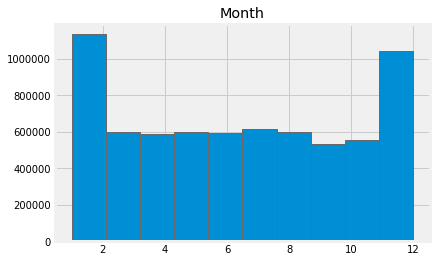

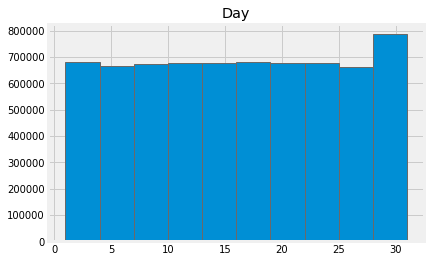

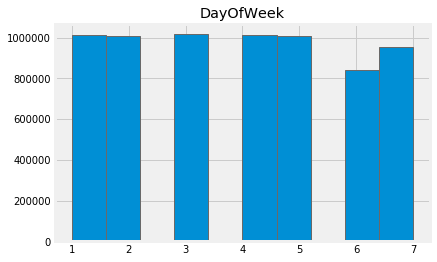

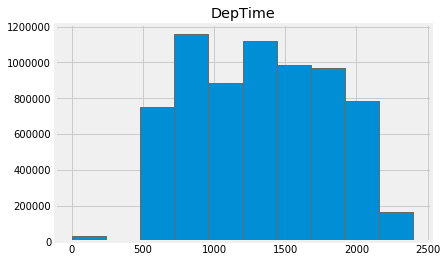

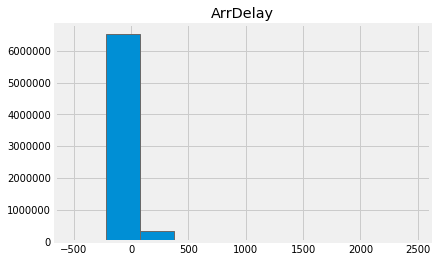

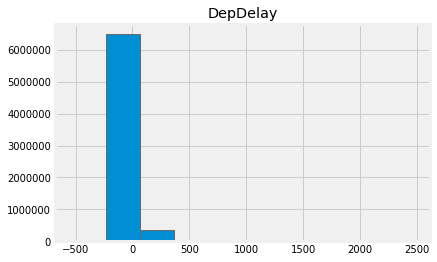

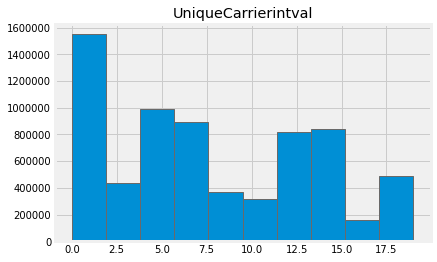

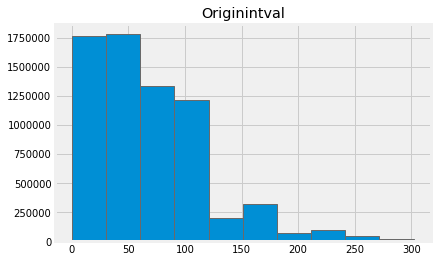

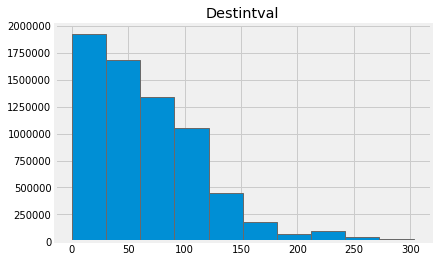

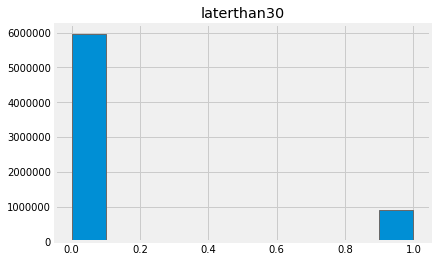

In [15]:
for col in columnsofval:
    df.hist(column=[col])
    plt.show()

                        Month       Day  DayOfWeek   DepTime  ArrDelay  \
Month                1.000000 -0.000402  -0.005350 -0.010321 -0.042058   
Day                 -0.000402  1.000000   0.004762 -0.001555  0.001607   
DayOfWeek           -0.005350  0.004762   1.000000  0.005660  0.010558   
DepTime             -0.010321 -0.001555   0.005660  1.000000  0.178275   
ArrDelay            -0.042058  0.001607   0.010558  0.178275  1.000000   
DepDelay            -0.030498  0.003299   0.015425  0.201981  0.931391   
UniqueCarrierintval -0.000895  0.001173   0.008628 -0.013451  0.025368   
Originintval         0.006068  0.000171   0.002376 -0.007476  0.021594   
Destintval           0.003932  0.000057   0.001438  0.008307  0.022773   
laterthan30         -0.035434 -0.000153   0.010525  0.190729  0.739601   

                     DepDelay  UniqueCarrierintval  Originintval  Destintval  \
Month               -0.030498            -0.000895      0.006068    0.003932   
Day                  0.00

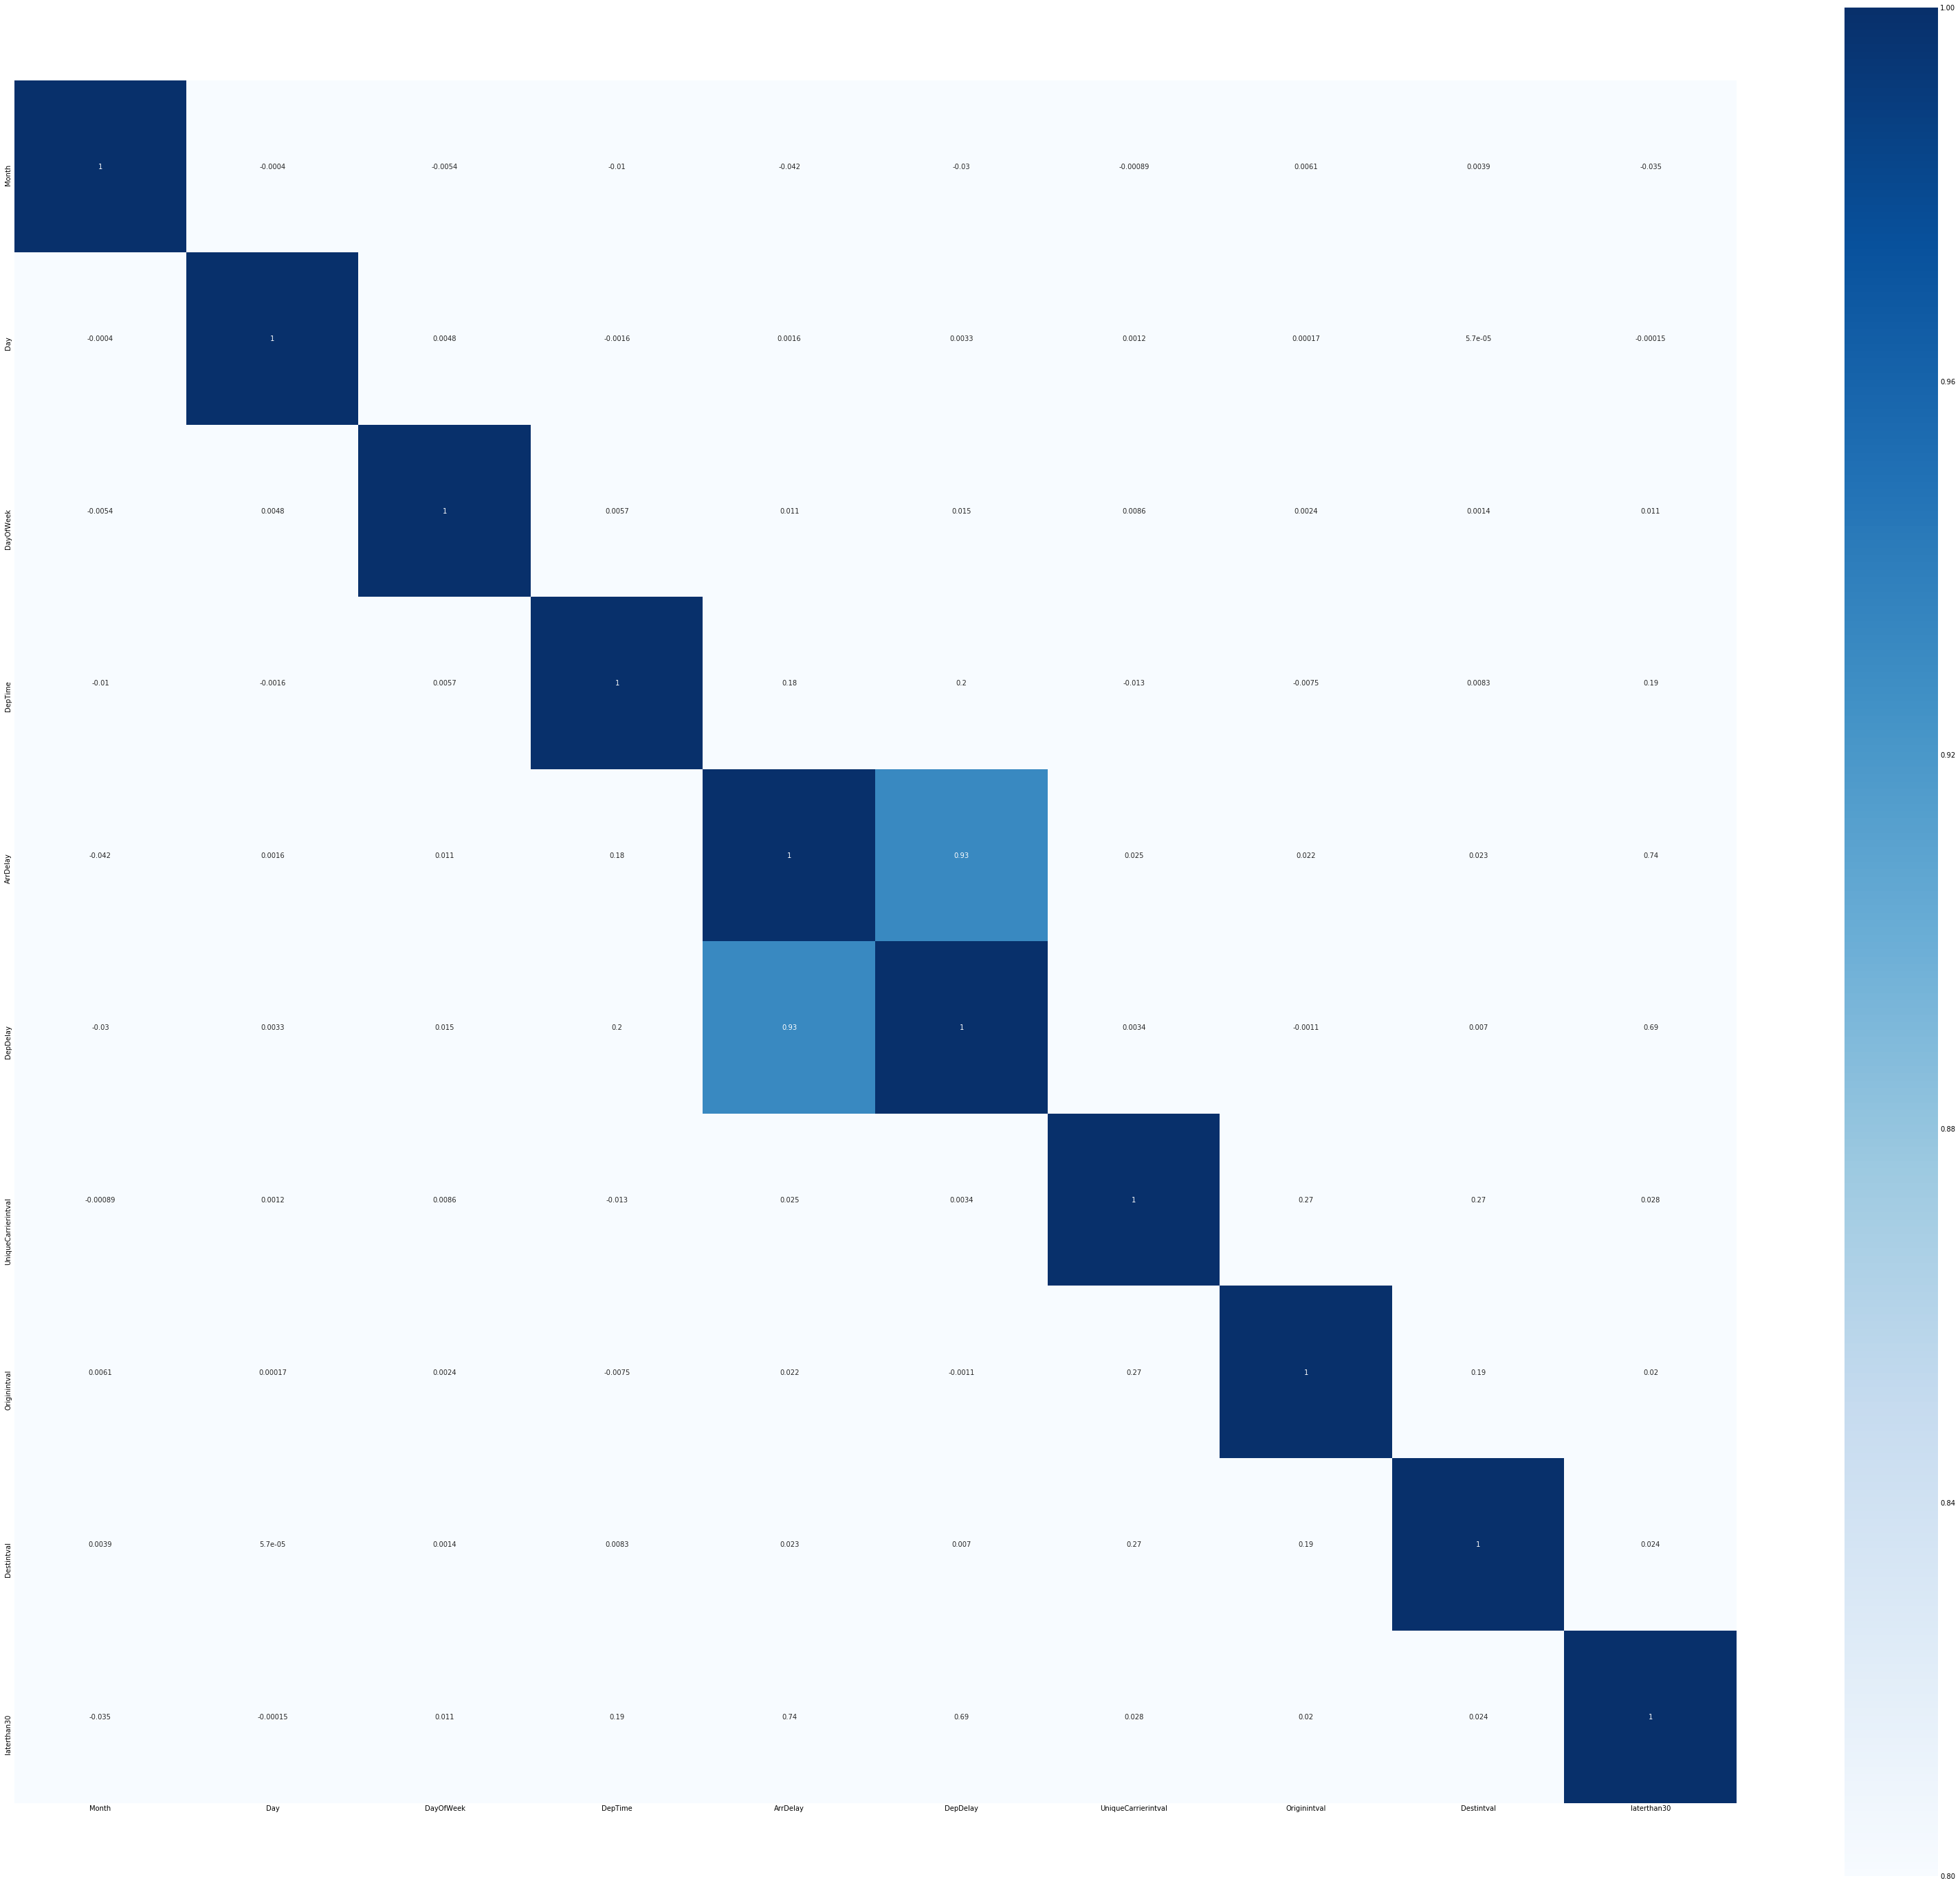

,Month,Day,DayOfWeek,DepTime,ArrDelay,DepDelay,UniqueCarrierintval,Originintval,Destintval,laterthan30
Month,1.000000,-0.000402,-0.005350,-0.010321,-0.042058,-0.030498,-0.000895,0.006068,0.003932,-0.035434
Day,-0.000402,1.000000,0.004762,-0.001555,0.001607,0.003299,0.001173,0.000171,0.000057,-0.000153
DayOfWeek,-0.005350,0.004762,1.000000,0.005660,0.010558,0.015425,0.008628,0.002376,0.001438,0.010525
DepTime,-0.010321,-0.001555,0.005660,1.000000,0.178275,0.201981,-0.013451,-0.007476,0.008307,0.190729
ArrDelay,-0.042058,0.001607,0.010558,0.178275,1.000000,0.931391,0.025368,0.021594,0.022773,0.739601
DepDelay,-0.030498,0.003299,0.015425,0.201981,0.931391,1.000000,0.003414,-0.001079,0.007034,0.686122
UniqueCarrierintval,-0.000895,0.001173,0.008628,-0.013451,0.025368,0.003414,1.000000,0.272747,0.272839,0.027711
Originintval,0.006068,0.000171,0.002376,-0.007476,0.021594,-0.001079,0.272747,1.000000,0.192876,0.019924
Destintval,0.003932,0.000057,0.001438,0.008307,0.022773,0.007034,0.272839,0.192876,1.000000,0.023888
laterthan30,-0.035434,-0.000153,0.010525,0.190729,0.739601,0.686122,0.027711,0.019924,0.023888,1.000000


In [16]:
corrmat = df.corr()
print(corrmat)
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(50, 50))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmin=.8, square=True, cmap="Blues", annot=True)
plt.show()
df.corr()

In [17]:
#sns.pairplot(df)

In [18]:
X = df.drop(['ArrDelay', 'laterthan30'], axis=1)

y = df['laterthan30']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [20]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()

In [21]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
prediction = logmodel.predict(X_test)

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(logmodel, X, y, cv=5)

array([0.95179747, 0.95741959, 0.95588495, 0.96154427, 0.95688054])

In [24]:
from sklearn.metrics import classification_report

In [25]:
classification_report(y_test, prediction)

'              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.98   1786021\n           1       0.90      0.76      0.83    270488\n\n   micro avg       0.96      0.96      0.96   2056509\n   macro avg       0.93      0.87      0.90   2056509\nweighted avg       0.96      0.96      0.96   2056509\n'

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
confusion_matrix(y_test, prediction)

array([[1764013,   22008],
       [  64438,  206050]], dtype=int64)

In [28]:
pd.crosstab(y_test, prediction)

col_0,0,1
laterthan30,,
0,1764013,22008
1,64438,206050


In [29]:
from sklearn.metrics import accuracy_score

In [30]:
from sklearn.feature_selection import RFE

selector = RFE(logmodel)
selector = selector.fit(X_train, y_train)

In [31]:
rankings = pd.DataFrame({'Features': X.columns, 'Ranking' : selector.ranking_})
rankings.sort_values('Ranking')

,Features,Ranking
0,Month,1
2,DayOfWeek,1
4,DepDelay,1
5,UniqueCarrierintval,1
6,Originintval,2
7,Destintval,3
1,Day,4
3,DepTime,5


# Linear model starts here.

In [32]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [33]:
df = pd.read_csv('2008y.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________


Dataframe dimensions: (7009728, 29)


In [34]:
#creating integer values for catagorical variables
#Could also do this with
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#le.fit(df['Col1'])
#df['Col3'] = le.transform(df['Col3'])

mapping1 = {k: v for v, k in enumerate(df.UniqueCarrier.unique())}
df['UniqueCarrierintval'] = df.UniqueCarrier.map(mapping1)

mapping2 = {k: v for v, k in enumerate(df.Origin.unique())}
df['Originintval'] = df.Origin.map(mapping2)

mapping3 = {k: v for v, k in enumerate(df.Dest.unique())}
df['Destintval'] = df.Dest.map(mapping3)

In [35]:
df.rename(columns={'DayofMonth':'Day'}, inplace=True)

In [36]:

#dropping redundant columns or columns that are more than 50% null values
df.drop(['Year', 'TailNum', 'Cancelled', 'CancellationCode', 'WeatherDelay', 'TaxiIn',
         'TaxiOut','CarrierDelay', 'NASDelay','SecurityDelay', 'LateAircraftDelay', 'TailNum','UniqueCarrier', 'Origin', 'Dest',
        'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'AirTime', 'Diverted', 'FlightNum', 'ActualElapsedTime', 
         'ArrTime', 'Distance'], axis=1, inplace=True)

#df.drop(['Year', 'Month', 'Day', 'TailNum', 'Cancelled', 'CancellationCode', 'WeatherDelay', 'TaxiIn',
#          'TaxiOut','CarrierDelay', 'NASDelay','SecurityDelay', 'LateAircraftDelay', 'TailNum'], axis=1, inplace=True)

In [37]:
#dropping about 30000 rows, many of these were flights that never took off
print(df.shape)
df = df.dropna(how='any', axis=0)
print(df.shape)

(7009728, 9)
(6855029, 9)


In [38]:
X = df.drop(['ArrDelay'], axis=1)
y = df['ArrDelay']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [40]:
from sklearn import linear_model
reg = linear_model.LinearRegression()


In [41]:
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [42]:
print(reg.coef_)
print(reg.intercept_)
print('Train Score :', reg.score(X_train, y_train))
print('Test Score:', reg.score(X_test, y_test))

[-1.57567068e-01 -5.97789799e-03 -7.76703934e-02 -8.25902251e-04
  1.02032186e+00  9.66177647e-02  1.25694388e-02  6.69070941e-03]
-1.4967194054841464
Train Score : 0.8683982905626144
Test Score: 0.8692438243611367


In [43]:
from sklearn import metrics
print('MSE :', metrics.mean_squared_error(y_test, y_pred))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MSE : 194.80722040026996
RMSE : 13.957335719981446
